# Cases in London

The graphs below use the data from <https://coronavirus.data.gov.uk/>. Daily cases per region is not available, but they do provide the raw data in <https://coronavirus.data.gov.uk/downloads/csv/coronavirus-cases_latest.csv>. Note that the data are now shown by the date the specimen was taken from the person being tested. This gives a much more useful analysis of the progression of cases over time. It does mean that the latest days’ figures are always incomplete, and **only data from 5 days or more ago can be considered complete**. Because of that, in the graphs below, we only use data from 5 days ago or previous.

In [1]:
import datetime
import gzip
import io
import time

import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import requests

In [2]:
# Parameters
secondary_axis = False

In [3]:
pd.options.plotting.backend = "plotly"

In [4]:
content = requests.get("https://coronavirus.data.gov.uk/downloads/csv/coronavirus-cases_latest.csv").content
with gzip.open(f"coronavirus-cases-{round(time.time())}.csv.gz", "wb") as fp:
    fp.write(content)
latest = io.StringIO(content.decode("utf-8"))
df = pd.read_csv(latest)

In [5]:
df["Specimen date"] = pd.to_datetime(df["Specimen date"])
most_recent_date = df["Specimen date"].max()
#df = df[df["Specimen date"] < (most_recent_date - datetime.timedelta(days=5))]

In [6]:
print("Lastest data available:", most_recent_date)
print("Last update:", datetime.datetime.utcnow())

Lastest data available: 2020-08-25 00:00:00
Last update: 2020-08-25 19:32:56.693127


In [7]:
def create_region_df(df, region):
        df = df[df["Area name"] == region]
        df = df.rename(columns={"Daily lab-confirmed cases": "Daily"})
        df = df[["Specimen date", "Daily"]]
        df = df.groupby("Specimen date").max()

        df["Cummulative"] = df["Daily"].cumsum()

        return df


def plot(df, regions):
    fig = make_subplots(
        cols=1,
        rows=len(regions),
        shared_xaxes=True,
        specs=[[{"secondary_y": True}]] * len(regions) if secondary_axis else None,
        subplot_titles=regions,
        vertical_spacing=0.02
    )
    for i, region in enumerate(regions):
        region_df = create_region_df(df, region)

        fig.add_trace(
            go.Bar(
                x=region_df.index,
                y=region_df.Daily,
                name="Daily",
                legendgroup="Daily",
                marker={"color": "blue"},
                showlegend=True if i == 0 else False,
            ),
            row=i + 1,
            col=1
        )
        daily_resample = region_df.resample("D").sum()
        rolling = daily_resample.Daily.rolling(20).sum()
        fig.add_trace(
            go.Scatter(
                x=daily_resample.index,
                y=rolling,
                name="Rolling sum (20 days)",
                legendgroup="Rolling",
                mode="lines+markers",
                marker={"color": "green"},
                showlegend=True if i == 0 else False,
            ),
            secondary_y=secondary_axis,
            row=i + 1,
            col=1
        )

    first_good_date = most_recent_date - datetime.timedelta(days=5)
    fig.update_layout(shapes=[
        {"type": "line", "yref": "paper", "y0": 0, "y1": 1, "xref": "x", "x0": first_good_date, "x1": first_good_date, "line": {"dash": "dot", "color": "DarkRed"}}
    ])
    fig.update_yaxes(title_text="Daily Cases" if secondary_axis else "Daily Cases & Rolling sum")
    if secondary_axis:
        fig.update_yaxes(title_text="Rolling sum", secondary_y=True)
    fig.update_layout(height=1800)
    fig.show()


def plot_cum(df, regions):
    fig = make_subplots(
        cols=1,
        rows=len(regions),
        shared_xaxes=True,
        subplot_titles=regions,
        vertical_spacing=0.02,
    )
    for i, region in enumerate(regions):
        region_df = create_region_df(df, region)

        fig.add_trace(
            go.Scatter(
                x=region_df.index,
                y=region_df.Cummulative,
                name="Cummulative",
                legendgroup="Cummulative",
                mode="lines+markers",
                marker={"color": "red"},
                showlegend=True if i == 0 else False,
            ),
            row=i + 1,
            col=1
        )

    first_good_date = most_recent_date - datetime.timedelta(days=5)
    fig.update_layout(shapes=[
        {"type": "line", "yref": "paper", "y0": 0, "y1": 1, "xref": "x", "x0": first_good_date, "x1": first_good_date, "line": {"dash": "dot", "color": "DarkRed"}}
    ])
    fig.update_yaxes(title_text="Cummulative Cases")
    fig.update_layout(height=1800)
    fig.show()

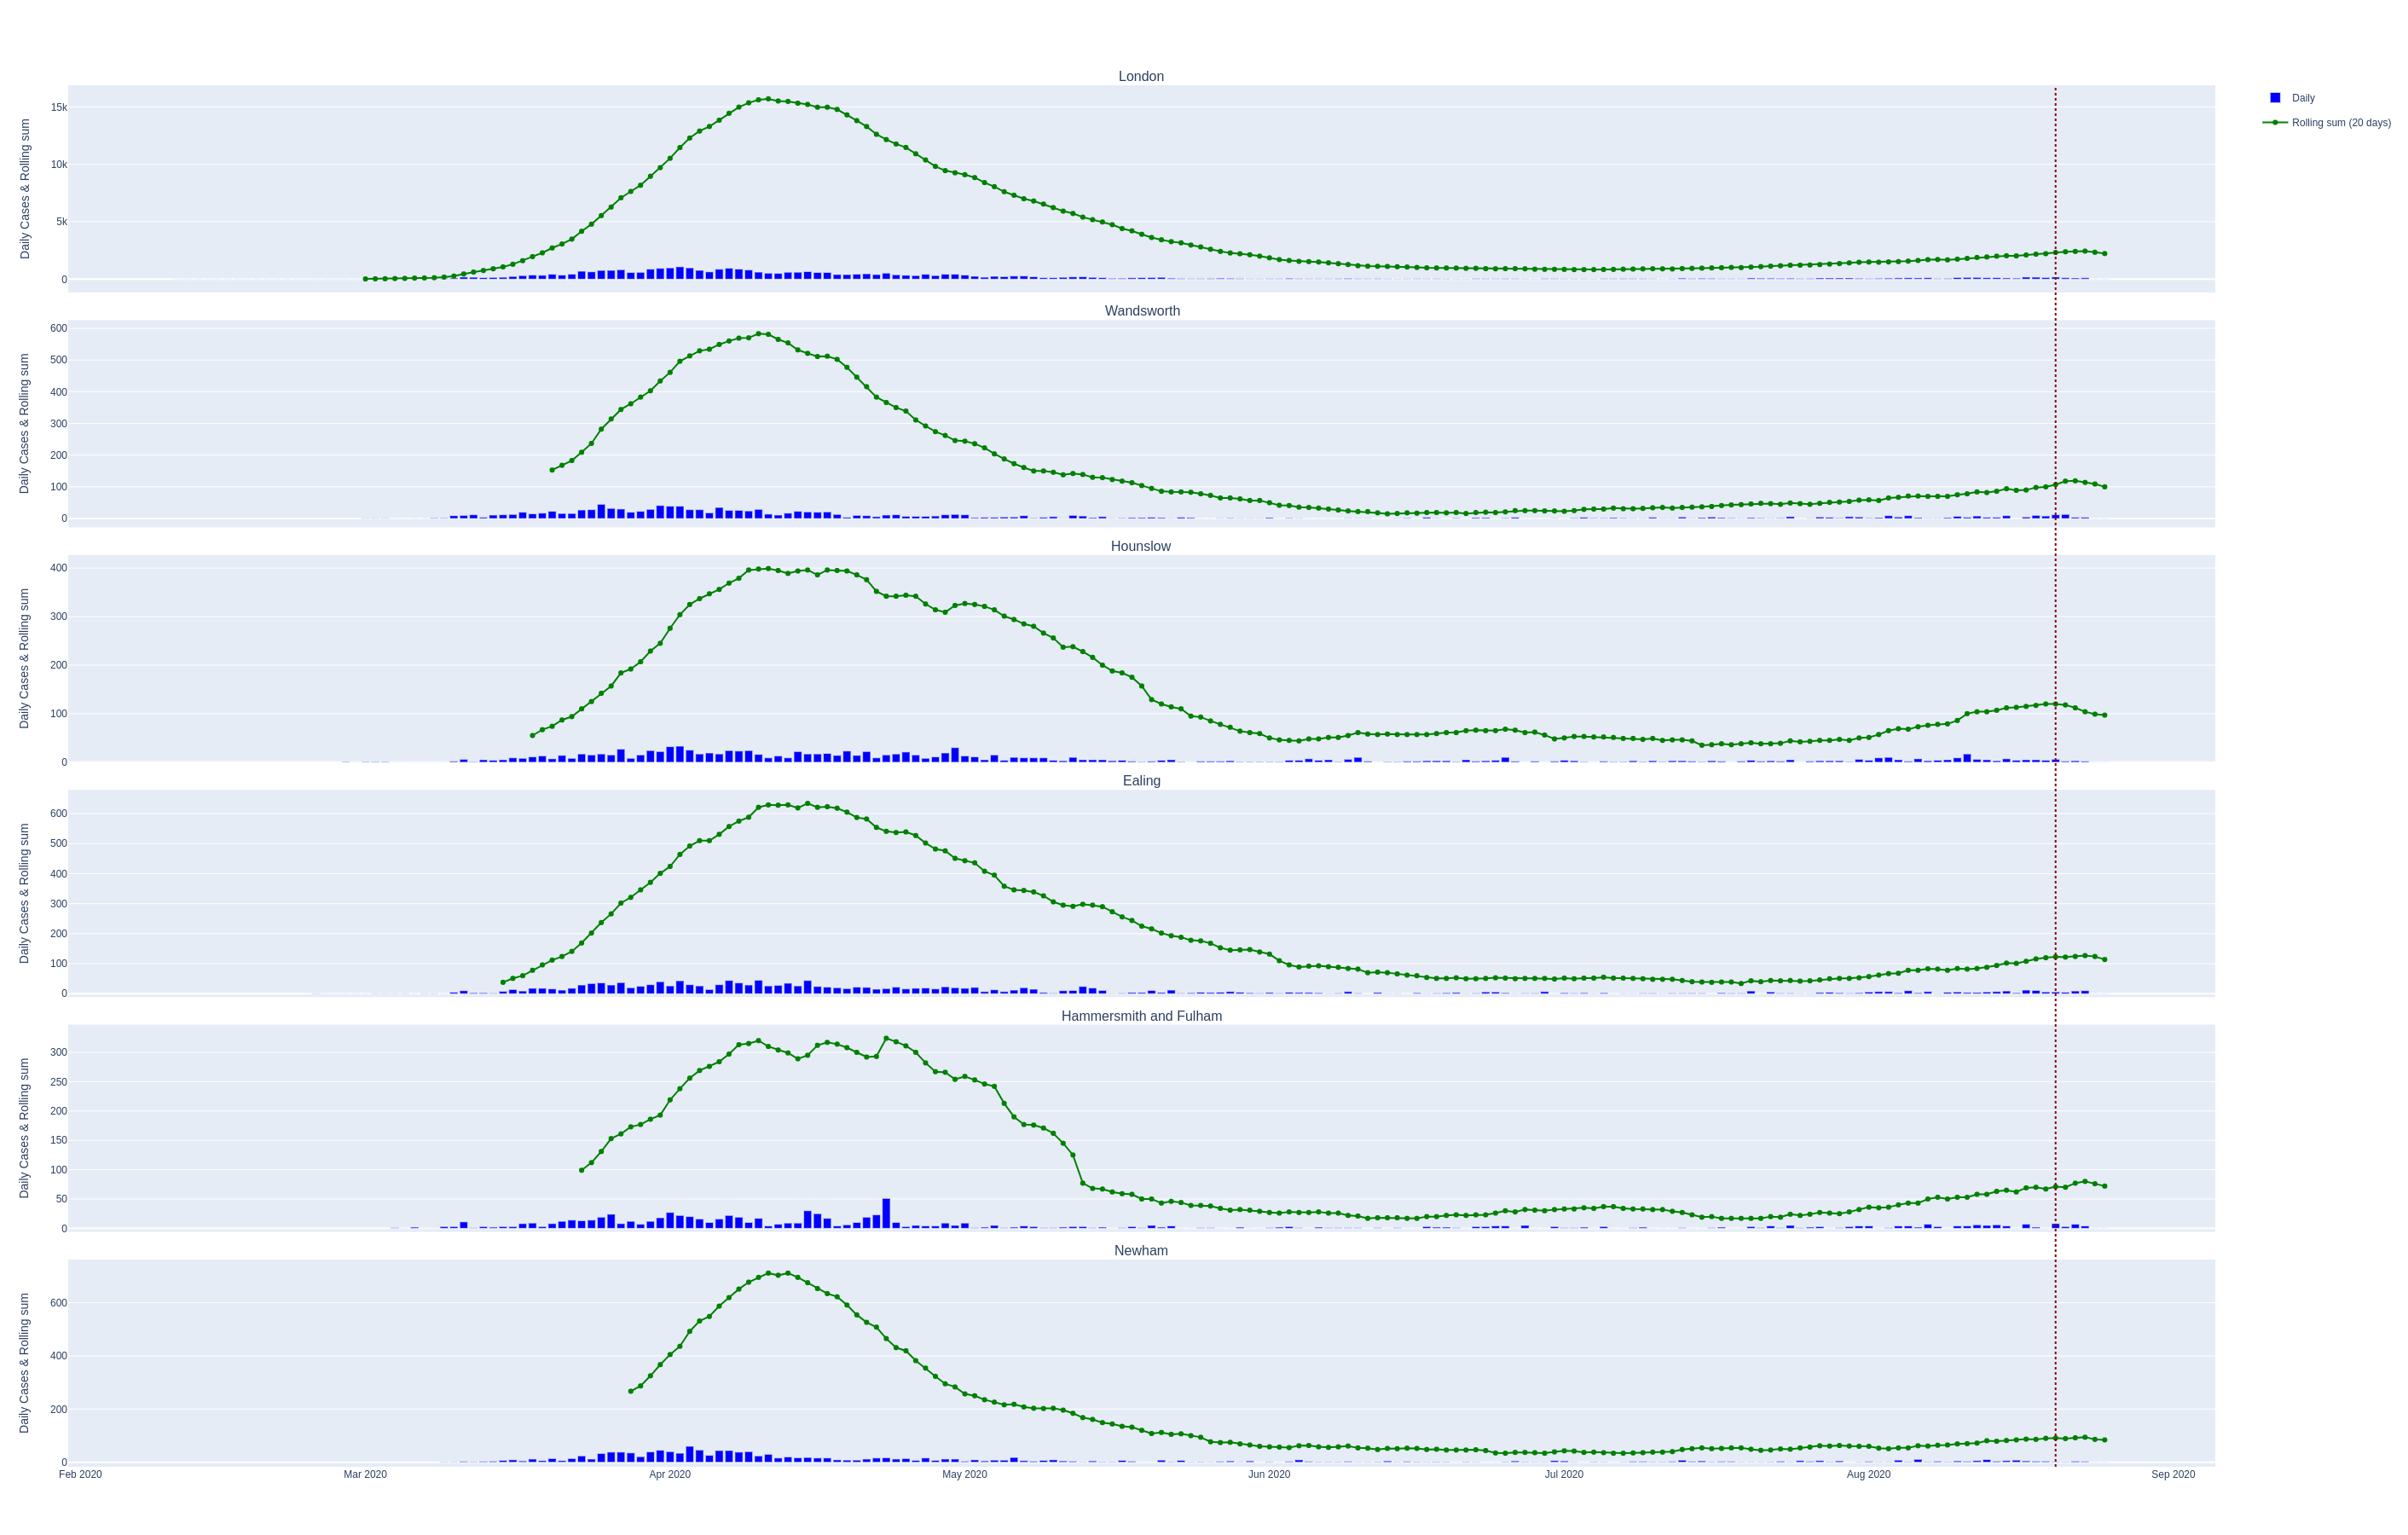

In [8]:
plot(df, ["London", "Wandsworth", "Hounslow", "Ealing", "Hammersmith and Fulham", "Newham"])

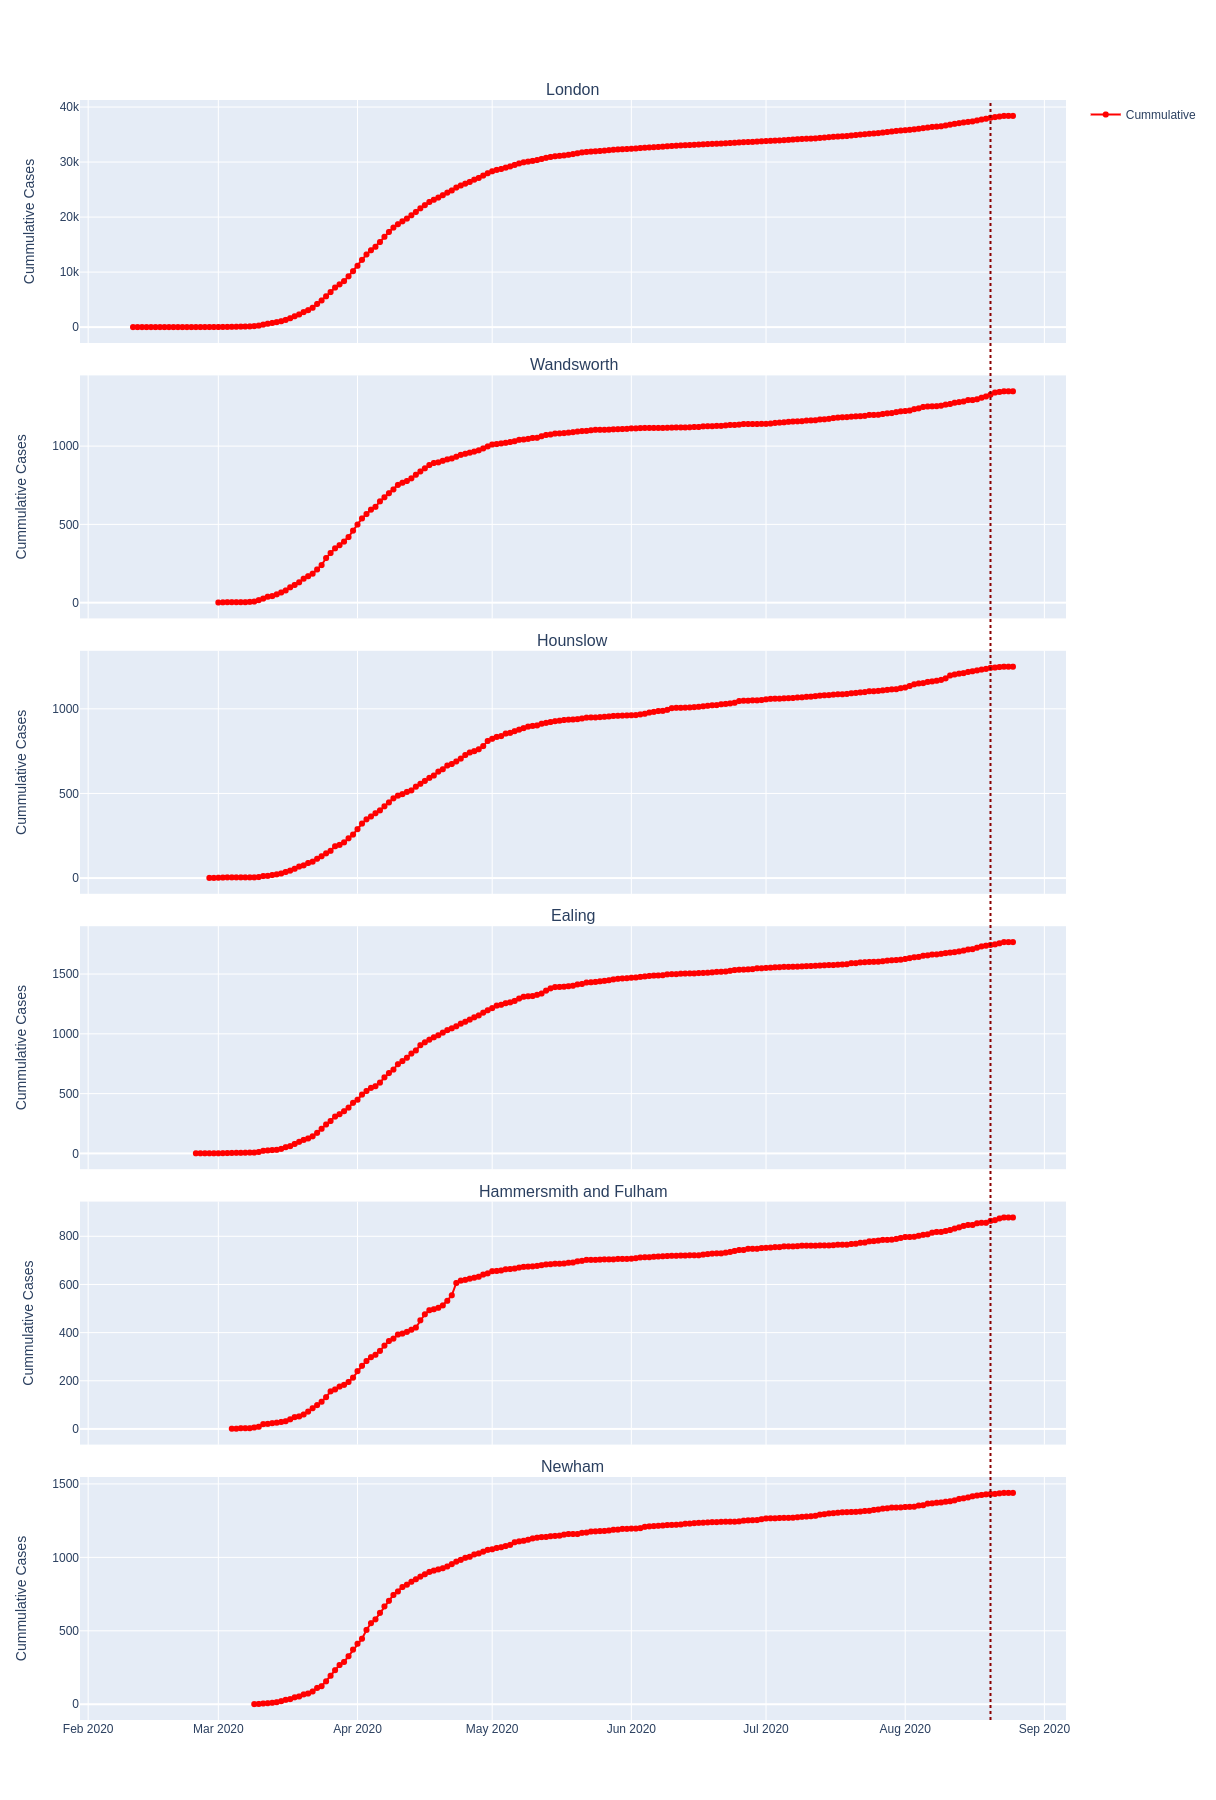

In [9]:
plot_cum(df, ["London", "Wandsworth", "Hounslow", "Ealing", "Hammersmith and Fulham", "Newham"])